# MOF Recommender System: Analyzing data

In [31]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os

<p style="text-align: center;">=====================================================================================================</p>

The following notebook is split up into two sections: <b>[Data Manipulation](#data_manipulation)</b> and <b>[Data Visualization](#data_visualization)</b>

<a id='data_manipulation'></a>
# Data Manipulation

### Creating a Dictionary that converts InChIKey to gas and hashkey to mof

In [32]:
host = "adsorption.nist.gov"

In [33]:
#Creating a dictionary of InChIKey to gas names 
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

#Creates a dictionary for hashkeys to material names
url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

### Taking out non experimental isotherms (excluding uncategorized isotherm)

In [34]:
url = "https://" + host + "/isodb/api/isotherms.json"
isotherm_data = json.loads(requests.get(url).content)

experimental_isotherm = []
print("Number of isotherms before cutting non experimental: {}".format(len(isotherm_data)))

for isotherm in reversed(isotherm_data):
    if isotherm['category'] == 'exp' or isotherm['category'] == '':
        experimental_isotherm.append(isotherm)

print("Number of isotherms after cutting non experimental: {}".format(len(experimental_isotherm)))

Number of isotherms before cutting non experimental: 30326
Number of isotherms after cutting non experimental: 28813


### Grabs units

In [35]:
filename = 'isotherm_file_units.csv'
units = []
filename_unit_dict = {}

# If `isotherm_file_units.csv` is not present, the following code will parse the database 
#  and grab the units of each isotherm file. The data will be written into a new `isotherm_file_units.csv` file
# WILL TAKE AROUND 3 HRS!
if os.path.isfile(filename):
    isotherm_unit_data = pd.read_csv(filename)
    units = isotherm_unit_data['units']
    for i in range(isotherm_unit_data.shape[0]):
        filename_unit_dict[isotherm_unit_data['isotherm_filename'][i]] = isotherm_unit_data['units'][i]
else:
    for isotherm in experimental_isotherm:
        filename = isotherm['filename']
        url = "https://adsorption.nist.gov/isodb/api/isotherm/" + filename + ".json"
        bibliography = json.loads(requests.get(url).content)
        units.append(bibliography['adsorptionUnits'])
        filename_unit_dict[filename] = bibliography['adsorptionUnits']
    with open(filename, 'w') as outfile:
        outfile.write('isotherm_filename,units\n')
        for i, isotherm in enumerate(experimental_isotherm):
            outfile.write(isotherm['filename'] + ',' + units[i] + '\n')

### This takes out MOFS with non viable units, binary/tertiary isotherms, and spits out numbers the gases and the mofs

In [37]:
viable_units = ['cm3(STP)/g','g/g','mg/g','ml/g','mmol/g','mmol/kg','mol/g','wt%']
boolean_isotherm_array = [x_i in viable_units for x_i in units]
n2_inchikey = 'IJGRMHOSHXDMSA-UHFFFAOYSA-N'
ar_inchikey = 'XKRFYHLGVUSROY-UHFFFAOYSA-N'

print("Number of Isotherms before cutting non viable units and gas mixtures: {}" .format(np.sum(boolean_isotherm_array)))

#Makes the boolean array false if the the units aren't viable or the gas is a mixture
for i_isotherm in range(len(experimental_isotherm)):
    if boolean_isotherm_array[i_isotherm] and len(experimental_isotherm[i_isotherm]['adsorbates']) > 1:
        boolean_isotherm_array[i_isotherm] = False
    if not ((experimental_isotherm[i_isotherm]['temperature'] < 303 and experimental_isotherm[i_isotherm]['temperature'] > 293) or
    (experimental_isotherm[i_isotherm]['adsorbates'][0]['InChIKey'] == n2_inchikey and experimental_isotherm[i_isotherm]['temperature'] == 77) or
           (experimental_isotherm[i_isotherm]['adsorbates'][0]['InChIKey'] == ar_inchikey and experimental_isotherm[i_isotherm]['temperature'] == 87)):
        boolean_isotherm_array[i_isotherm] = False
        
print("Number of Isotherms after cutting non viable units and gas mixtures: {}" .format(np.sum(boolean_isotherm_array)))

#TODO make temperature specifications for each of the isotherms, probably make another conditional statement about the temperature

#The below two for loops take every experimental mof and gas and number them 
count = 0
mof_to_row = {}
for isotherm in range(len(experimental_isotherm)):
    if boolean_isotherm_array[isotherm] and experimental_isotherm[isotherm]['adsorbent']['hashkey'] not in mof_to_row:
        mof_to_row[experimental_isotherm[isotherm]['adsorbent']['hashkey']] = count
        count += 1

row_to_mof = dict(map(reversed, mof_to_row.items())) #creates an inverted dictionary

count = 0
gas_to_column = {}
for isotherm in range(len(experimental_isotherm)):
    if boolean_isotherm_array[isotherm] and experimental_isotherm[isotherm]['adsorbates'][0]['InChIKey'] not in gas_to_column:
        gas_to_column[experimental_isotherm[isotherm]['adsorbates'][0]['InChIKey']] = count
        count += 1
        
column_to_gas = dict(map(reversed, gas_to_column.items())) #creates an inverted dictionary

print("Number of gases in the matrix: {}".format(len(gas_to_column)))
print("Number of mofs in the matrix: {}".format(len(mof_to_row)))



Number of Isotherms before cutting non viable units and gas mixtures: 24878
Number of Isotherms after cutting non viable units and gas mixtures: 11442
Number of gases in the matrix: 80
Number of mofs in the matrix: 3741


### This fills in the matrix

In [39]:
#Setting up a matrix of mofs and gases for available data and frequency of isotherms
mof_gas_matrix = np.zeros((len(mof_to_row),len(gas_to_column)))
mof_gas_frequency = np.zeros((len(mof_to_row),len(gas_to_column)))

#Now to fill in the matrix
for isotherm in range(len(experimental_isotherm)):
    if boolean_isotherm_array[isotherm]:
        row_value = mof_to_row[experimental_isotherm[isotherm]['adsorbent']['hashkey']]
        column_value = gas_to_column[experimental_isotherm[isotherm]['adsorbates'][0]['InChIKey']]
        mof_gas_matrix[row_value,column_value] = 1
        mof_gas_frequency[row_value,column_value] += 1

### Checking to see if all gas mixtures were successfully "taken out" of experimental_isotherm

In [40]:
for (i, isotherm) in enumerate(experimental_isotherm):
    if len(isotherm['adsorbates']) > 1:
        assert not boolean_isotherm_array[i]
    assert filename_unit_dict[isotherm['filename']] in viable_units or not boolean_isotherm_array[i]

### This takes a random value from the matrix to see if there is isotherm data on it and prints the isotherm data if present

In [41]:
count = 1
while True:
    gas_number = random.choice(range(len(gas_to_column)))
    mof_number = random.choice(range(len(mof_to_row)))
    if mof_gas_matrix[mof_number,gas_number] == 1:
        for isotherm in experimental_isotherm:
            if isotherm['adsorbent']['hashkey'] == row_to_mof[mof_number] and isotherm['adsorbates'][0]['InChIKey'] == column_to_gas[gas_number]:
                url = "https://adsorption.nist.gov/isodb/api/isotherm/" + isotherm['filename'] + ".json"
                bibliography = json.loads(requests.get(url).content)
                if bibliography['adsorptionUnits'] in viable_units and len(bibliography['adsorbates']) == 1 and isotherm['category'] in ['exp', '']:
                    print('Isotherm ' + str(count) + ' satisfies all conditions!')
                #pprint.pprint(bibliography) <-- if you want to check the actual isotherm file
                count += 1
        break

Isotherm 1 satisfies all conditions!
Isotherm 2 satisfies all conditions!
Isotherm 3 satisfies all conditions!
Isotherm 4 satisfies all conditions!
Isotherm 5 satisfies all conditions!
Isotherm 6 satisfies all conditions!


### Another Check to see if the matrix is correct

In [42]:
#This just tests to see if the matrix is correct, you can see the amount of gases each isotherm has and compare it to the matrix
#material_code[experimental_isotherm[12]['adsorbent']['hashkey']] correspnds with the first term in the matrix 'CuBTC'
#Code should give 53 different gases that 'CuBTC' has been tested with because that is the number that the number of ones in the sparsity matrix

CuBTC_hashkey = 'NIST-MATDB-991daf7313251e7e607e2bab2da57e33'
test_array=[]
for isotherm in range(len(experimental_isotherm)):
    if experimental_isotherm[isotherm]['adsorbent']['hashkey'] == CuBTC_hashkey and boolean_isotherm_array[isotherm]:
        test_array.append(key_to_gas[experimental_isotherm[isotherm]['adsorbates'][0]['InChIKey']])

print('The gases that are tested with CuBTC:') 
pprint.pprint(set(test_array))
print('Number of gases in the list: {}'.format(len(set(test_array))))
print('Number of gasses in the first row of the matrix that corresponds with CuBTC: {}'.format(np.sum(mof_gas_matrix[0,:])))

The gases that are tested with CuBTC:
{'Acetone',
 'Acetylene',
 'Ammonia',
 'Argon',
 'Benzene',
 'Carbon Dioxide',
 'Carbon Tetrachloride',
 'Carbon Tetrafluoride',
 'Carbon monoxide',
 'Dichloromethane',
 'Ethane',
 'Ethanol',
 'Ethene',
 'Hydrogen',
 'Methane',
 'Methanol',
 'N-Butane',
 'N-Hexane',
 'N-propane',
 'Nitric oxide',
 'Nitrogen',
 'Oxygen',
 'Sulfur dioxide',
 'Thiophene',
 'Trichloromethane',
 'Water',
 'Xenon'}
Number of gases in the list: 27
Number of gasses in the first row of the matrix that corresponds with CuBTC: 15.0


### This takes out rows and columns that have too little data

In [43]:
def prune_matrix(min_data_points, verbose=True):
    keep_row = np.ones(len(mof_to_row), dtype=bool)
    keep_column = np.ones(len(gas_to_column), dtype=bool)
    nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
    gases_cut = 0
    mofs_cut = 0
    count = 0

    while True:
        for i_row in range(len(mof_to_row)):
            if np.sum(mof_gas_matrix[i_row, keep_column]) < min_data_points:
                keep_row[i_row] = False

        for i_column in range(len(gas_to_column)):
            if np.sum(mof_gas_matrix[keep_row, i_column]) < min_data_points:
                keep_column[i_column] = False

        if nb_kept_rows_and_columns == (np.sum(keep_row) + np.sum(keep_column)):
            break

        nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
        count += 1

    mofs_cut = np.sum(~keep_row)
    gases_cut = np.sum(~keep_column)

    #TODO make another matrix that actually cuts the rows and the columns out
    if verbose:
        print("Number of mofs cut: {}" .format(mofs_cut))
        print("Number of gases cut: {}" .format(gases_cut))
        print('The remaining dimensions of the matrix are {} by {}'.format(len(mof_to_row)-mofs_cut,len(gas_to_column)-gases_cut))
        print('The number of iterations of sparsing the matrix {}'.format(count))
    
    return keep_row, keep_column

keep_row, keep_column = prune_matrix(5)

Number of mofs cut: 3614
Number of gases cut: 48
The remaining dimensions of the matrix are 127 by 32
The number of iterations of sparsing the matrix 2


### Grabs individual isotherms for further analysis

In [44]:
for isotherm in experimental_isotherm:
    filename = isotherm['filename']
    if os.path.isfile('isotherms/' + filename + '.json'):
        #print(filename + '.json already exists')
        continue
    url = "https://adsorption.nist.gov/isodb/api/isotherm/" + filename + ".json"
    isotherm_data = json.loads(requests.get(url).content)
    with open('isotherms/' + filename + '.json', 'w') as outfile:
        json.dump(isotherm_data, outfile)

<a id='data_visualization'></a>
# Data Visualization

In [45]:
def sort_matrix_by_freq(mof_gas_matrix, row_or_col):
    assert row_or_col in ['row', 'col']
    row_or_col_axis = np.int(row_or_col == 'row')
    row_or_col_sum = np.sum(mof_gas_matrix, axis=row_or_col_axis)
    len_other_axis = mof_gas_matrix.shape[row_or_col_axis]
    old_order = np.array([i for i in range(len(row_or_col_sum))])
    new_order = sorted(old_order, key=lambda x: row_or_col_sum[x], reverse=True)
    other_axis_order = np.array([i for i in range(len_other_axis)])
    if row_or_col == 'row':
        return mof_gas_matrix[new_order, :]
    else:
        return mof_gas_matrix[:, new_order]

### Analyzing the categories of the isotherms

The amount of uncategorized isotherms is 23090
The amount of epxerimental isotherms is 5723
The amount of modelled isotherms is 460
The amount of quantum isotherms is 118
The amount of simulated isotherms is 935


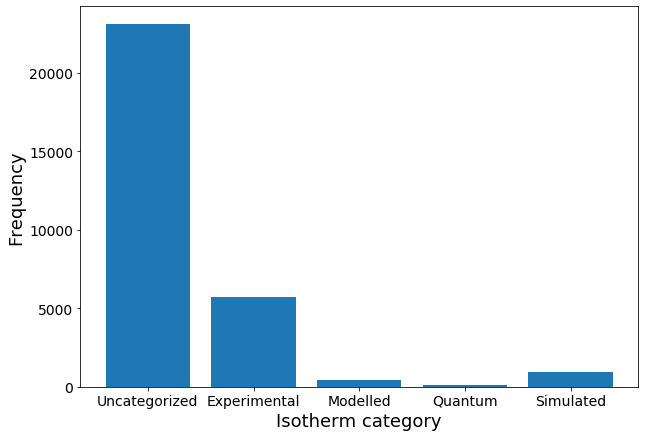

In [46]:
isotherm_category = []
for isotherm in isotherm_data:
    isotherm_category.append(isotherm['category'])

n_uncategorized = isotherm_category.count('')
n_experimental = isotherm_category.count('exp')
n_mod = isotherm_category.count('mod')
n_qua = isotherm_category.count('qua')
n_simulated = isotherm_category.count('sim')

print('The amount of uncategorized isotherms is {}'.format(n_uncategorized))
print('The amount of epxerimental isotherms is {}'.format(n_experimental))
print('The amount of modelled isotherms is {}'.format(n_mod))
print('The amount of quantum isotherms is {}'.format(n_qua))
print('The amount of simulated isotherms is {}'.format(n_simulated))


category_labels = ("Uncategorized", "Experimental", "Modelled", "Quantum", "Simulated")
y_pos = np.arange(len(category_labels))
bar_height = [n_uncategorized, n_experimental, n_mod, n_qua, n_simulated]

fig = plt.figure(figsize = (10,7))
ax = plt.gca()
ax.bar(y_pos, bar_height, align='center', alpha=1)
plt.xticks(y_pos, category_labels)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Isotherm category', fontsize=18)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)



plt.show()

### Analyzing the temperature ranges in the dataset

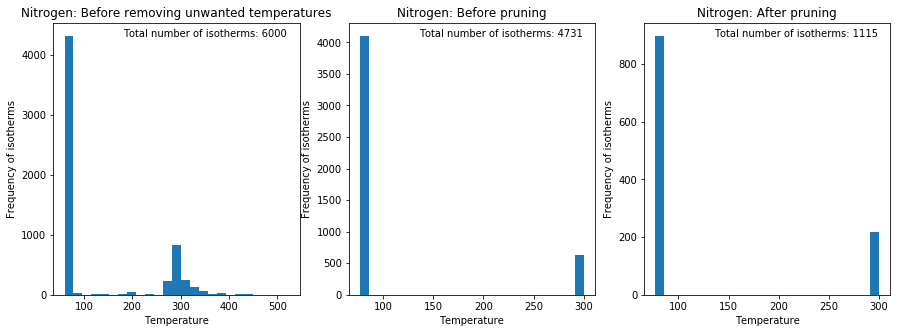

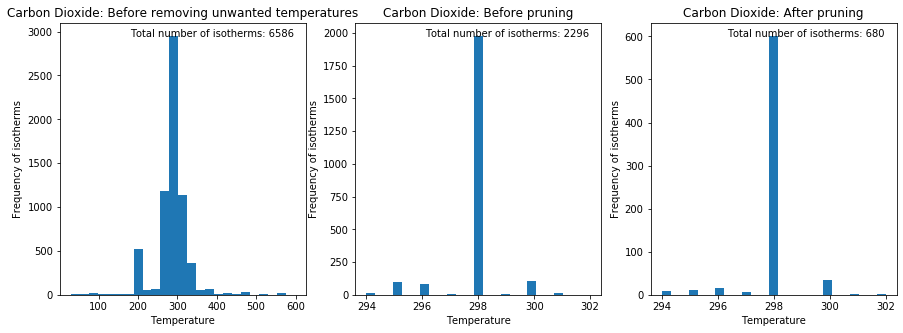

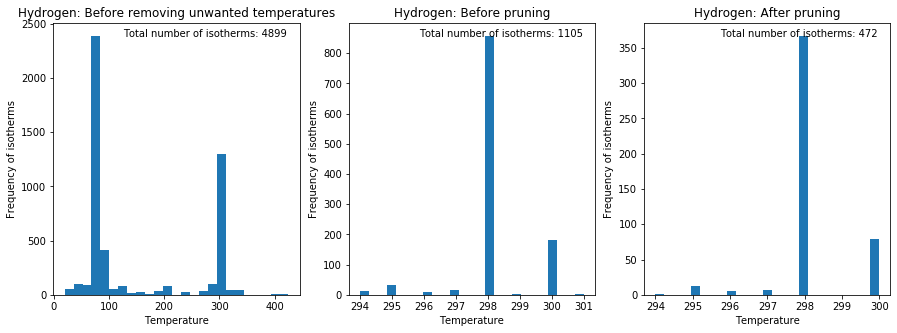

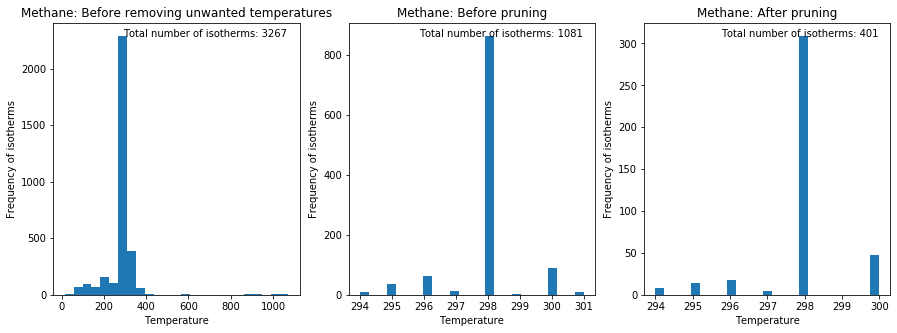

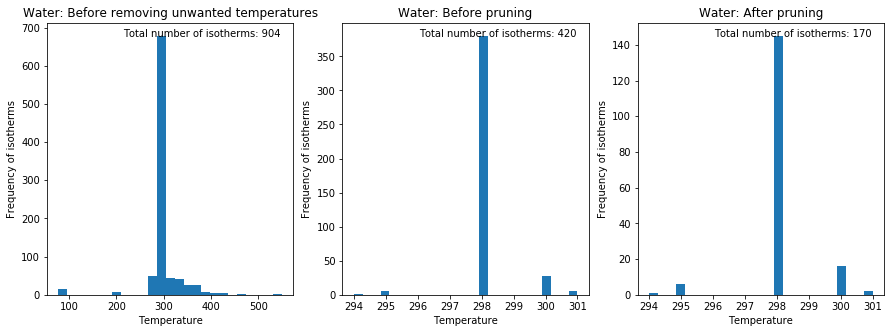

In [50]:
def inspect_temp_of_gas_isotherms(gas_name, min_data_points_for_pruning):
    assert gas_name in gas_to_key.keys()
    inchikey = gas_to_key[gas_name]
    
    temp_before_before = []
    temp_before = []
    temp_after = []
    for isotherm in np.array(experimental_isotherm):
        if isotherm['adsorbates'][0]['InChIKey'] == inchikey and len(isotherm['adsorbates']) < 2:
            temp_before_before.append(isotherm['temperature'])
    
    for isotherm in np.array(experimental_isotherm)[boolean_isotherm_array]:
        if isotherm['adsorbates'][0]['InChIKey'] == inchikey and len(isotherm['adsorbates']) < 2:
            temp_before.append(isotherm['temperature'])
    
    keep_row, keep_column = prune_matrix(min_data_points_for_pruning, False)
    for isotherm in np.array(experimental_isotherm)[boolean_isotherm_array]:
        i_col = gas_to_column[isotherm['adsorbates'][0]['InChIKey']]
        i_row = mof_to_row[isotherm['adsorbent']['hashkey']]
        if keep_row[i_row] and keep_column[i_col] and isotherm['adsorbates'][0]['InChIKey'] == inchikey and len(isotherm['adsorbates']) < 2:
            temp_after.append(isotherm['temperature'])

    def create_subplot(ax, temp, title_label):
        ax.hist(temp, bins=25)
        ax.set_xlabel('Temperature')
        ax.set_ylabel('Frequency of isotherms')
        ax.set_title(title_label)
        ax.text(0.95, 0.95, 'Total number of isotherms: {}'.format(len(temp)), 
            horizontalalignment='right', transform=ax.transAxes)
        
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    create_subplot(axs[0], temp_before_before, gas_name + ': Before removing unwanted temperatures')
    create_subplot(axs[1], temp_before, gas_name + ': Before pruning')
    create_subplot(axs[2], temp_after, gas_name + ': After pruning')
    plt.show()
    
sums = np.sum(mof_gas_frequency, axis=0)
old_order = np.array([i for i in range(len(sums))])

new_order = sorted(old_order, key=lambda x: sums[x], reverse=True)
most_common_gases = [key_to_gas[column_to_gas[i]] for i in new_order]


for gas in most_common_gases[:5]:
    inspect_temp_of_gas_isotherms(gas, 5)

## Plotting the sparsed matrix and the original matrix side by side

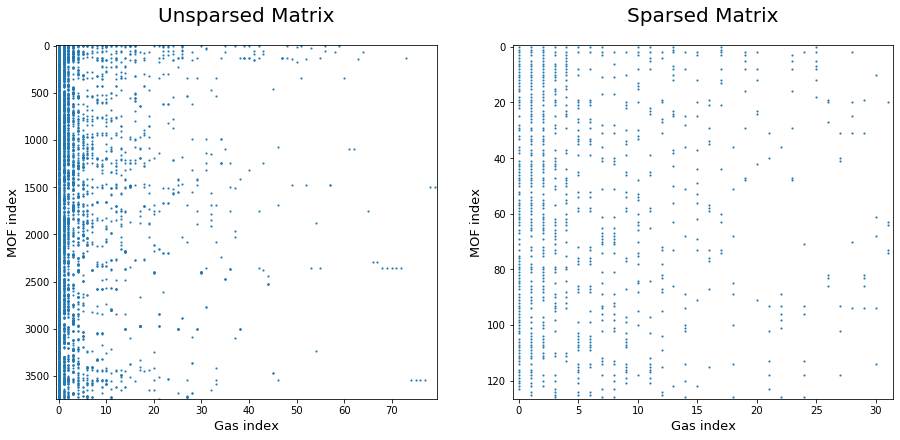

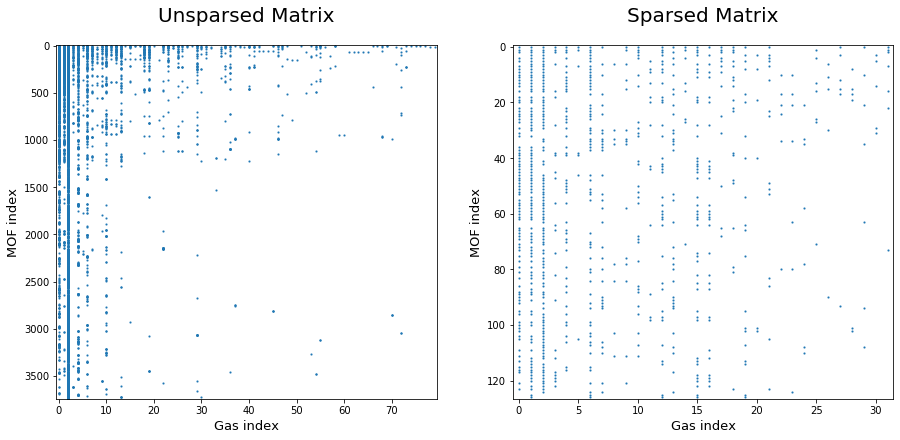

In [16]:
def plot_sparsity(col_or_row, min_data_points):
    assert col_or_row in ['col', 'row']
    
    keep_row, keep_column = prune_matrix(min_data_points, False)
    fig = plt.figure(figsize = (15,6.5))

    #subplot for the unsparsed matrix
    sorted_matrix = sort_matrix_by_freq(mof_gas_matrix, col_or_row) 
    ax = plt.subplot(121)
    plt.spy(sorted_matrix, aspect='auto', markersize=1)
    plt.title('Unsparsed Matrix',fontsize = 20)
    plt.xlabel('Gas index',fontsize = 13)
    plt.ylabel('MOF index',fontsize = 13)
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')


    #subplot the sparsed matrix 
    sorted_sparsed_matrix = sort_matrix_by_freq(np.copy(mof_gas_matrix[keep_row, :][:, keep_column]), col_or_row)
    ax = plt.subplot(122)
    plt.spy(sorted_sparsed_matrix, aspect = 'auto',markersize=1)
    plt.title('Sparsed Matrix',fontsize = 20)
    plt.xlabel('Gas index',fontsize = 13)
    plt.ylabel('MOF index',fontsize = 13)
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_label_position('bottom')

    plt.show()

plot_sparsity('col', 5)
#plot_sparsity('row', 5)

# Plotting the frequency of isotherms per gas/MOF

['Carbon Dioxide', 'Methane', 'Nitrogen', 'Acetylene', 'Hydrogen', 'Nitric oxide', 'Water', 'Ethanol', 'Cyclohexane', 'Benzene', 'Argon', 'Propene', 'N-propane', 'Methanol', 'Xenon', 'Ethane', 'Ethene', 'Ammonia', 'Carbon monoxide', 'N-Butane', 'Isobutane', 'Oxygen', '2-Propanol', '1-Propanol', 'Acetonitrile', 'Krypton', 'Toluene', 'N-Hexane', 'N-Pentane', 'Acetone', 'Helium', 'Sulfur dioxide']


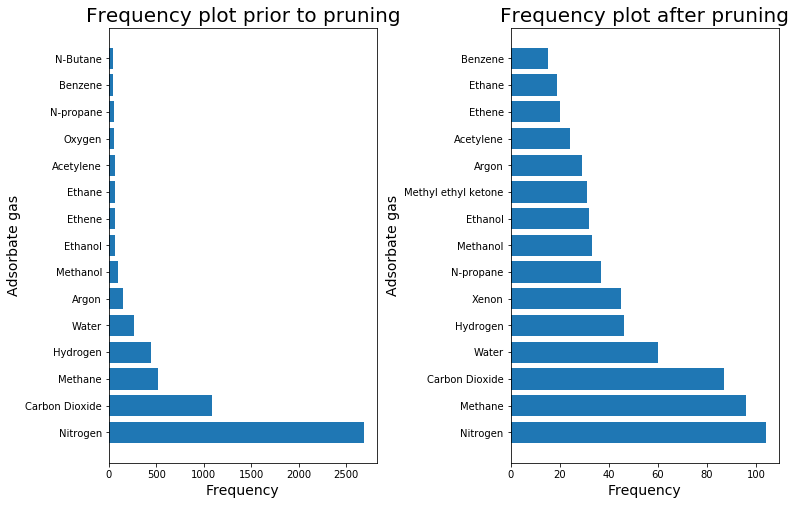

In [17]:
def plot_frequency_of_gas_or_mof(gas_or_mof, min_data_points_for_pruning):
    assert gas_or_mof.lower() in ['gas', 'mof']
    
    gas_or_mof_axis = np.int(gas_or_mof == 'mof')
    gas_or_mof_sum = np.sum(mof_gas_matrix, axis=gas_or_mof_axis)
    old_order = np.arange(len(gas_or_mof_sum))
    new_order = sorted(old_order, key=lambda x: gas_or_mof_sum[x], reverse=True)
    
    sums = np.sum(mof_gas_matrix, axis=gas_or_mof_axis)

    most_common_gases = np.full(len(sums), "", dtype='object')
    for (i, o) in enumerate(new_order):
        most_common_gases[i] = (key_to_gas[column_to_gas[o]])

    keep_row, keep_column = prune_matrix(min_data_points_for_pruning, False)
    gases_kept = [key_to_gas[column_to_gas[col]] for col in np.arange(mof_gas_matrix.shape[1])[keep_column]]
    
    gas_or_mof_sparsed_sum = np.sum(mof_gas_matrix[keep_row, :][:, keep_column], axis=gas_or_mof_axis)
    sparsed_old_order = np.arange(len(gas_or_mof_sparsed_sum))
    sparsed_new_order = sorted(sparsed_old_order, key=lambda x: gas_or_mof_sparsed_sum[x], reverse=True)
    
    sparsed_sums = np.sum(mof_gas_matrix[keep_row, :][:, keep_column], axis=gas_or_mof_axis)

    most_common_sparsed_gases = np.full(len(sparsed_sums), "", dtype='object')
    for (i, o) in enumerate(sparsed_new_order):
        most_common_sparsed_gases[i] = (key_to_gas[column_to_gas[o]])
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
    axs[0].barh(most_common_gases[0:15], gas_or_mof_sum[new_order][0:15])
    axs[0].set_xlabel('Frequency', fontsize=14)
    axs[0].set_ylabel('Adsorbate gas', fontsize=14)
    axs[0].set_title('Frequency plot prior to pruning', fontsize=20)
    axs[1].barh(most_common_sparsed_gases[0:15], gas_or_mof_sparsed_sum[sparsed_new_order][0:15])
    axs[1].set_xlabel('Frequency', fontsize=14)
    axs[1].set_ylabel('Adsorbate gas', fontsize=14)
    axs[1].set_title('Frequency plot after pruning', fontsize=20)
    
    fig.subplots_adjust(wspace=0.5)
    plt.show()
plot_frequency_of_gas_or_mof('gas', 5)

## Minimum data point requirement vs sparsity of matrix graph

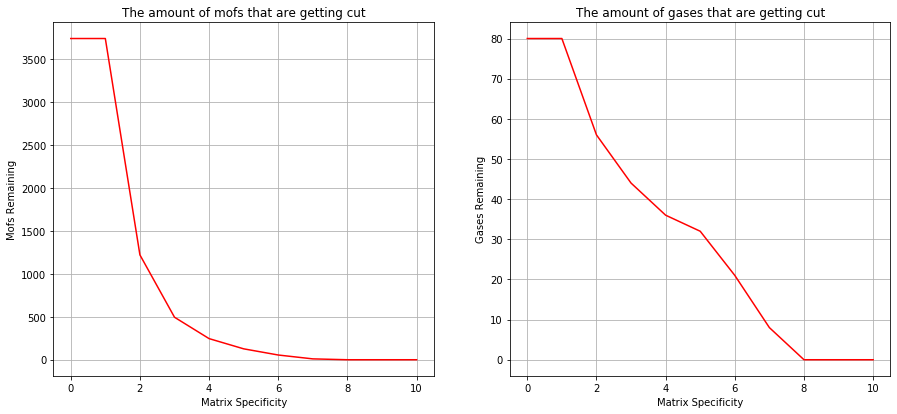

In [18]:
point_requirement_matrix = np.copy(mof_gas_matrix)
matrix_sum = np.sum(point_requirement_matrix)
gases_cut = 0
mofs_cut = 0
count = 0
cut_mofs = []
cut_gases = []

for n in range(11):
    while True:
        
        mofs_cut = 0
        gases_cut = 0
        
        for row in range(len(mof_to_row)):
            if np.sum(point_requirement_matrix[row,:]) < n:
                point_requirement_matrix[row,:] = False
        
        for column in range(len(gas_to_column)):
            if np.sum(point_requirement_matrix[:,column]) < n:
                point_requirement_matrix[:,column] = False
    
        if matrix_sum == np.sum(point_requirement_matrix):
            break
        
        matrix_sum = np.sum(point_requirement_matrix)
        count += 1
    
    for row in range(len(mof_to_row)):
        if point_requirement_matrix.sum(axis = 1)[row] == 0:
            mofs_cut += 1
    
    for column in range(len(gas_to_column)):
        if point_requirement_matrix.sum(axis = 0)[column] == 0:
            gases_cut += 1
            
    cut_mofs.append(len(mof_to_row) - mofs_cut)
    cut_gases.append(len(gas_to_column) - gases_cut)   

#Plots how the the gases and the mofs act with an increase in matrix specificity
n = range(11)
plt.figure(figsize = (15,6.5))

plt.subplot(121)
plt.plot(n,cut_mofs,'r')
plt.title('The amount of mofs that are getting cut')
plt.ylabel('Mofs Remaining')
plt.xlabel('Matrix Specificity')
plt.grid()

plt.subplot(122)
plt.plot(n,cut_gases,'r')
plt.title('The amount of gases that are getting cut')
plt.ylabel('Gases Remaining')
plt.xlabel('Matrix Specificity')
plt.grid()
plt.show()
#TODO plot the graphs as points

# Write Data Matrix to a Pandas DataFrame and write it to a file:

In [72]:
mof_gas_dataframe = pd.DataFrame(data=np.array(mof_gas_matrix[:, keep_column][keep_row, :]),
                                 columns=[column_to_gas[i] for i in np.arange(mof_gas_matrix.shape[1])[keep_column]],
                                 index=[row_to_mof[i] for i in np.arange(mof_gas_matrix.shape[0])[keep_row]],
                                dtype=int)

mof_gas_dataframe.to_csv('mof_gas_dataframe.csv')
mof_gas_dataframe

,CURLTUGMZLYLDI-UHFFFAOYSA-N,VNWKTOKETHGBQD-UHFFFAOYSA-N,IJGRMHOSHXDMSA-UHFFFAOYSA-N,HSFWRNGVRCDJHI-UHFFFAOYSA-N,UFHFLCQGNIYNRP-UHFFFAOYSA-N,MWUXSHHQAYIFBG-UHFFFAOYSA-N,XLYOFNOQVPJJNP-UHFFFAOYSA-N,LFQSCWFLJHTTHZ-UHFFFAOYSA-N,XDTMQSROBMDMFD-UHFFFAOYSA-N,UHOVQNZJYSORNB-UHFFFAOYSA-N,...,KFZMGEQAYNKOFK-UHFFFAOYSA-N,BDERNNFJNOPAEC-UHFFFAOYSA-N,WEVYAHXRMPXWCK-UHFFFAOYSA-N,DNNSSWSSYDEUBZ-UHFFFAOYSA-N,YXFVVABEGXRONW-UHFFFAOYSA-N,VLKZOEOYAKHREP-UHFFFAOYSA-N,OFBQJSOFQDEBGM-UHFFFAOYSA-N,CSCPPACGZOOCGX-UHFFFAOYSA-N,SWQJXJOGLNCZEY-UHFFFAOYSA-N,RAHZWNYVWXNFOC-UHFFFAOYSA-N
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,1,0,1,0,1
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,1,1,1,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
NIST-MATDB-9f02824618e94d86caedc9fb497366ba,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NIST-MATDB-acbbe796d49416e999dc819f2ae65fe9,1,1,1,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
NIST-MATDB-e23e0f3921a269533d74caae8c5a12bf,1,1,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
NIST-MATDB-b848f05ba9fb26cdd50755863b377c56,1,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,1,1,1,1,1,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
NIST-MATDB-71d6fc9e1d75f65e8a04544608290958,1,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
